# Apprentice Chef - Classification Model Development

> *by Jack Daoud, February 14th 2021*

# Setup

In [1]:
# Set up environment with libraries & data

##############################################################################
# Import libraries

import pandas as pd                     # data sceince essentials
import matplotlib.pyplot as plt         # essential graphical output
import seaborn as sns                   # enhanced visualizations
import numpy as np                      # mathematical essentials
from tqdm.notebook import tqdm          # progress bars
import time                             # time essentials
import itertools


from sklearn.model_selection import train_test_split # train-test split
from sklearn.linear_model import LogisticRegression  # logistic regression
import statsmodels.formula.api as smf                # logistic regression
from sklearn import metrics                          # metrics
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.metrics import classification_report    # classification report
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.cluster import KMeans                   # KMeans for segmentation
from sklearn.preprocessing import StandardScaler     # standard scaler


# Set Pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

##############################################################################
# Import data

# Specify file name
file_data = './_data/Feature_Rich_Dataset.xlsx'

# Read file into Python
chefs = pd.read_excel(io     = file_data,
                      header = 0)

t0 = time.time()            # start time of script

In [85]:
# User defined functions

########################################
# optimal_neighbors
########################################
def optimal_neighbors(X_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(X_data)
        X_scaled           = scaler.transform(X_data)
        X_scaled_df        = pd.DataFrame(X_scaled)
        X_data             = X_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(X_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    

########################################
# confusion_matrix
########################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("""
Normalized confusion matrix""")
#    else:
#        print("""
#Confusion matrix, without normalization""")

#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Source of function: ML with Python by IBM on Coursera

########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 1000, width = 1600):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = X_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

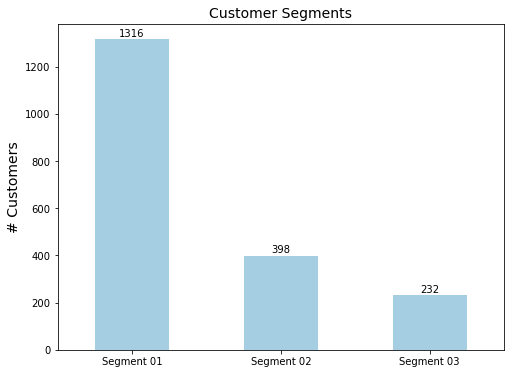

In [3]:
# K-Means Customer Segment Variable with REVENUE

# Drop clusters built from Regression notebook
chefs.drop(['KMEANS_CLUSTER_1', 'KMEANS_CLUSTER_2'], axis = 1, inplace = True)

# Instantiate scaler
scaler = StandardScaler()

# Subset for explanatory variables for customer segmentation EXCLUDING REVENUE
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin(['log_REVENUE',
                         'log_AVG_PREP_VID_TIME',
                         'log_AVG_TIME_PER_SITE_VISIT',
                         'log_CONTACTS_W_CUSTOMER_SERVICE',
                         'CROSS_SELL_SUCCESS'])]].values

# Fit the scaler with our data for customer segmentation
scaler.fit(X)

# Fit the scaler with our data for customer segmentation
X_scaled = scaler.transform(X)

# Instantiate number of clusters
clusterNum = 3

# Instantiate KMEANS model
k_means = KMeans(init         = "k-means++", 
                 n_clusters   = clusterNum, 
                 n_init       = 12,
                 random_state = 219)

# Fit the model
k_means.fit(X_scaled)

# Grab each label (segmentation) for each customer
k_means_labels = k_means.labels_

# Add cluster labels to data set
chefs["KMEANS_CLUSTERS"] = k_means_labels

# Display cluster average per variable
#chefs.groupby('KMEANS_CLUSTERS').mean()

##############################################################################
# Plot 

# Count number of churn per month
genders = chefs['KMEANS_CLUSTERS'].value_counts()

# Create plot
ax = genders.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title("Customer Segments", size = 14)
ax.set_xticklabels(labels = ['Segment 01', "Segment 02", "Segment 03"])
ax.legend().remove()
 
# Display plot
plt.show()
#plt.close()


##############################################################################
# Plot elbow point for optimal K

# Placeholder
#distortions = []

# Number of Ks
#K = range(1,10)

# Loop through each K
#for k in K:
#    kmeanModel = KMeans(n_clusters=k)
#    kmeanModel.fit(X)                            # Fit with X
#    distortions.append(kmeanModel.inertia_)      # Append inertia to distortions
    
# "Inertia can be recognized as a measure of how internally coherent clusters are."
# https://scikit-learn.org/stable/modules/clustering.html

# Plot elbow point
#plt.figure(figsize=(16,8))
#plt.plot(K, distortions, 'bx-')
#plt.xlabel('k')
#plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k')
#plt.show()

# Source:
# https://predictivehacks.com/k-means-elbow-method-code-for-python/


##############################################################################
# Convert KMEANS_CLUSTERS into Dummy Variables

# Get dummy variables for KMEANS_CLUSTERS
one_hot_Clusters = pd.get_dummies(chefs['KMEANS_CLUSTERS'])

# Rename columns
one_hot_Clusters.columns = ['KMEANS_CLUSTER_0', 'KMEANS_CLUSTER_1', 'KMEANS_CLUSTER_2']

# Drop cluster 0 to follow n-1 
one_hot_Clusters.drop('KMEANS_CLUSTER_1', axis = 1, inplace = True)


# Drop KMEANS_CLUSTER 
chefs = chefs.drop('KMEANS_CLUSTERS', axis = 1)

# Join dummy variables back to Chefs dataframe
chefs = chefs.join([one_hot_Clusters])

# Response Variable Exploration

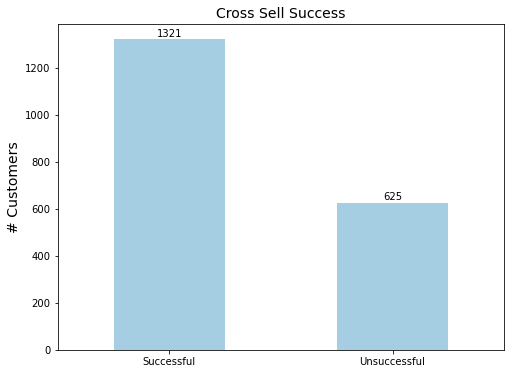


Proportions:
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64


In [4]:
# CROSS_SELL_SUCCESS Proportions
cross_sell = chefs['CROSS_SELL_SUCCESS'].value_counts()

# Create plot
ax = cross_sell.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title("Cross Sell Success", size = 14)
ax.set_xticklabels(labels = ['Successful', "Unsuccessful"])
ax.legend().remove()
 
# Display plot
plt.show()

print(f"""
Proportions:
{chefs['CROSS_SELL_SUCCESS'].value_counts(normalize = True).round(decimals = 2)}""")

In [5]:
chefs['CROSS_SELL_SUCCESS'].mean()

0.6788283658787256

In [6]:
# CROSS_SELL Correlations

# Create correlation dataframe
df_corr = chefs.corr(method = 'pearson')

# Display correlations with CROSS_SELL_SUCCESS
df_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

CROSS_SELL_SUCCESS                      1.000000
LAST_NAME                               0.242167
DOMAIN_GROUP_PROFESSIONAL               0.194102
CANCELLATIONS_BEFORE_NOON               0.163442
TOTAL_CANCELS                           0.142681
EARLY_CANCELLATION                      0.138611
MOBILE_NUMBER                           0.102657
CANCELED                                0.099748
TASTES_AND_PREFERENCES                  0.081438
REFRIGERATED_LOCKER                     0.068321
LEARNER                                 0.049939
log_CONTACTS_W_CUSTOMER_SERVICE         0.046711
PC_LOGINS                               0.044462
PACKAGE_LOCKER                          0.043534
DOMAIN_GROUP_PERSONAL                   0.038841
ABOVE_AVG_CONTACT_W_CS                  0.037903
MASTER_CLASSES_ATTENDED                 0.037213
CONTACTS_W_CUSTOMER_SERVICE             0.036541
log_AVG_PREP_VID_TIME                   0.034529
AVG_PREP_VID_TIME                       0.032115
MEDIAN_MEAL_RATING  

# Models

## Logistic Regression


=================== MODEL SUMMARY ===================

Model Type: Logistic Regression

Model Size: 59

---------------------------------

LR Training Score : 0.7718
LR Testing Score  : 0.7392
LR AUC Score         : 0.6607

---------------------------------

                           precision    recall  f1-score   support

    Cross Sell Failed (0)       0.63      0.44      0.52       156
Cross Sell Successful (1)       0.77      0.88      0.82       331

                 accuracy                           0.74       487
                macro avg       0.70      0.66      0.67       487
             weighted avg       0.73      0.74      0.72       487



Coefficients:

                                      Coefficient
DOMAIN_GROUP_PROFESSIONAL                0.977778
DOMAIN_GROUP_PERSONAL                    0.693500
LAST_NAME                                0.589362
AVG_PREP_VID_TIME                        0.470470
KMEANS_CLUSTER_0                         0.455211
TOTAL_CANCELS     

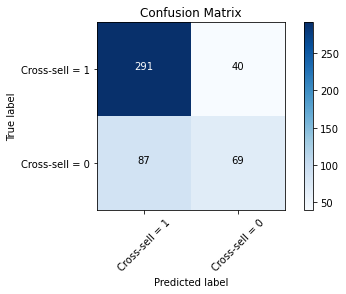

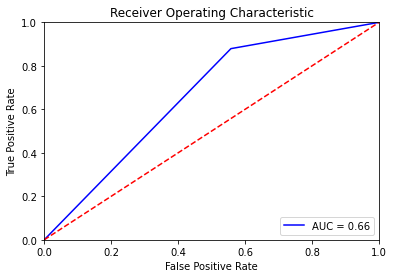

In [111]:
# Base Logistic Model

# Specify explanatory variables
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin([
        
        # y-variable
        'CROSS_SELL_SUCCESS',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                        
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        'high_out_WEEKLY_PLAN',
        'low_out_WEEKLY_PLAN',
    
        # log exclusions (4 total)
        'log_AVG_TIME_PER_SITE_VISIT',
        'log_AVG_PREP_VID_TIME',
        'log_CONTACTS_W_CUSTOMER_SERVICE',
        'log_REVENUE'])]]

# Instantiate scaler
scaler = StandardScaler()

# Fit scaler
scaler.fit(X)

# Transform explanatory variables
X_scaled = scaler.transform(X)

# Specify response variable
y = chefs.loc[:, 'CROSS_SELL_SUCCESS']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X_scaled,
            y,
            test_size    = 0.25,
            random_state = 219,
            stratify     = y)


# Instantiate inverse weights for model
#W = {0:68, 1:32}

# Instantiate a logistic regression model
LR = LogisticRegression(solver       = 'lbfgs',
                        C            = 1,
                        random_state = 219,
#                        class_weight = W,
                        max_iter     = 10000)

# Fit the logistic model
LR = LR.fit(X_train, y_train)

# Predict on test set
LR_pred = LR.predict(X_test)


# Create a dataframe of variable coefficients
lr_coeff = pd.DataFrame(LR.coef_[0], X.columns, columns=['Coefficient'])

# Filter out coefficients that equal 0 and sort by descending
lr_coeff = lr_coeff[lr_coeff['Coefficient'] != 0]\
                    .sort_values('Coefficient', ascending = False)

# Instantiate scores
LR_train_score = LR.score(X_train, y_train).round(4)
LR_test_score  = LR.score(X_test, y_test).round(4)
LR_auc_score   = roc_auc_score(y_true  = y_test, y_score = LR_pred).round(4)
LR_report      = classification_report(y_test, 
                                       LR_pred,
                                       target_names = ['Cross Sell Failed (0)',
                                                       'Cross Sell Successful (1)'])
# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Logistic Regression

Model Size: {X.shape[1] + 1}

---------------------------------

LR Training Score : {LR_train_score}
LR Testing Score  : {LR_test_score}
LR AUC Score         : {LR_auc_score}

---------------------------------

{LR_report}


Coefficients:

{lr_coeff}
""")


##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
LR_tn, \
LR_fp, \
LR_fn, \
LR_tp = confusion_matrix(y_true = y_test, y_pred = LR_pred).ravel()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, LR_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Cross-sell = 1','Cross-sell = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = LR.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, LR_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

## Logistic with Stats

In [115]:
xlabels = chefs.columns[
    ~chefs.columns.isin([
        
        # y-variable
        'CROSS_SELL_SUCCESS',        
    
        # multi-collinearity
        'TOTAL_MEALS_ORDERED',                        
        'MEDIAN_MEAL_RATING',           
        'CANCELLATIONS_BEFORE_NOON',    
        'CANCELLATIONS_AFTER_NOON',     
        'MASTER_CLASSES_ATTENDED',      
        'EARLY_CANCELLATION',           
        'EARLY_DELIVERIES',             
        'TOTAL_PHOTOS_VIEWED',     
        'AVG_MEALS_ORDERED',
        'high_out_WEEKLY_PLAN',
        'low_out_WEEKLY_PLAN',
        'low_out_LATE_DELIVERIES',
    
        # log exclusions (4 total)
        'log_AVG_TIME_PER_SITE_VISIT',
        'log_AVG_PREP_VID_TIME',
        'log_CONTACTS_W_CUSTOMER_SERVICE',
        'log_REVENUE'])]

In [ ]:
for label in xlabels:
    print(f"{label} +")

In [ ]:
#

concat_train = pd.concat([X_train, y_train], axis = 1)

# instantiating a logistic regression model object
logit_sig = smf.logit(formula = """ CROSS_SELL_SUCCESS ~
UNIQUE_MEALS_PURCH +
PRODUCT_CATEGORIES_VIEWED +
MOBILE_NUMBER +
TASTES_AND_PREFERENCES +
PC_LOGINS +
MOBILE_LOGINS +
WEEKLY_PLAN +
LATE_DELIVERIES +
PACKAGE_LOCKER +
REFRIGERATED_LOCKER +
AVG_CLICKS_PER_VISIT +
log_REVENUE +
log_AVG_PREP_VID_TIME +
log_AVG_TIME_PER_SITE_VISIT +
log_CONTACTS_W_CUSTOMER_SERVICE +
TOTAL_CANCELS +
TOTAL_MEALS_DELIVERED +
CONTACTS_PER_ORDER +
VARIETY_OF_ORDERS +
LATE_MEAL_ORDER_RATIO +
MEALS_PER_CLICK +
VIEWED_PHOTOS +
EARLY_DELIVERY +
LATE_DELIVERY +
LATE_CANCELLATION +
CANCELED +
SUBSCRIBER +
LEARNER +
LAST_NAME +
MEAL_POLARITY +
ABOVE_AVG_CONTACT_W_CS +
GENDER +
DOMAIN_GROUP_PERSONAL +
DOMAIN_GROUP_PROFESSIONAL +
high_out_TOTAL_MEALS_ORDERED +
low_out_TOTAL_MEALS_ORDERED +
high_out_UNIQUE_MEALS_PURCH +
low_out_UNIQUE_MEALS_PURCH +
high_out_CONTACTS_W_CUSTOMER_SERVICE +
low_out_CONTACTS_W_CUSTOMER_SERVICE +
high_out_PRODUCT_CATEGORIES_VIEWED +
low_out_PRODUCT_CATEGORIES_VIEWED +
high_out_AVG_TIME_PER_SITE_VISIT +
low_out_AVG_TIME_PER_SITE_VISIT +
high_out_EARLY_DELIVERIES +
high_out_LATE_DELIVERIES +
high_out_AVG_PREP_VID_TIME +
low_out_AVG_PREP_VID_TIME +
high_out_AVG_MEALS_ORDERED +
low_out_AVG_MEALS_ORDERED +
high_out_MASTER_CLASSES_ATTENDED +
high_out_MEDIAN_MEAL_RATING +
high_out_AVG_CLICKS_PER_VISIT +
low_out_AVG_CLICKS_PER_VISIT +
high_out_TOTAL_PHOTOS_VIEWED +
KMEANS_CLUSTER_1 +
KMEANS_CLUSTER_2""",
                                            data    = concat_train)


# fitting the model object
logit_sig = logit_sig.fit()


# checking the results SUMMARY
logit_sig.summary()

## Trees

In [112]:
# libraries for classification trees
from sklearn.tree import DecisionTreeClassifier   # classification trees
from sklearn.tree import export_graphviz          # exports graphics
from six import StringIO                          # saves objects in memory
from IPython.display import Image                 # displays on frontend
import pydotplus                                  # interprets dot objects


=================== MODEL SUMMARY ===================

Model Type: Decision Tree

---------------------------------

Base Tree Training Score : 0.7162
Base Tree Testing Score  : 0.7228
Base Tree AUC Score      : 0.6945

---------------------------------

                           precision    recall  f1-score   support

    Cross Sell Failed (0)       0.63      0.44      0.52       156
Cross Sell Successful (1)       0.77      0.88      0.82       331

                 accuracy                           0.74       487
                macro avg       0.70      0.66      0.67       487
             weighted avg       0.73      0.74      0.72       487





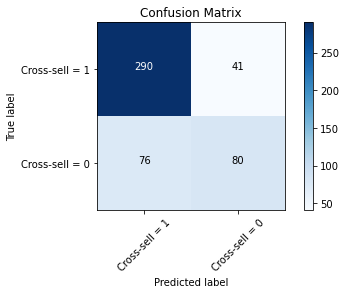

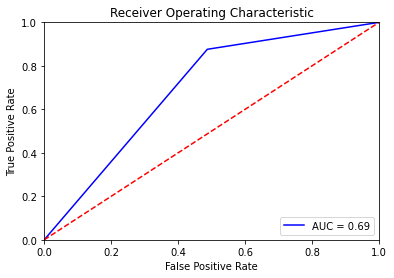

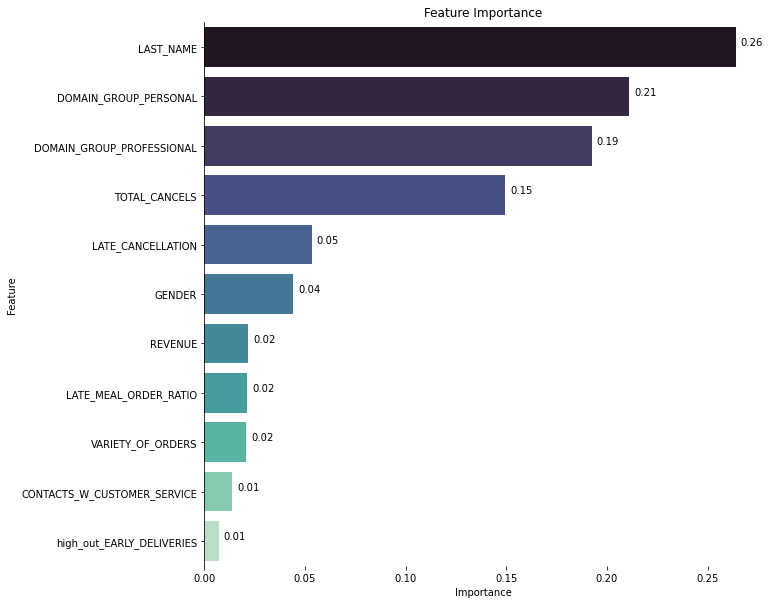

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [113]:
# Base Tree Model

# Instantiate a classification tree object
baseTree = DecisionTreeClassifier(max_depth = 4,
                                  min_samples_leaf = 25,
                                  random_state = 219)

# Fit the training data
baseTree = baseTree.fit(X_train, y_train)


# Predict cross-selling
baseTree_pred = baseTree.predict(X_test)

# Save scores
baseTree_train_score = full_tree_fit.score(X_train, y_train).round(4) # accuracy
baseTree_test_score  = full_tree_fit.score(X_test, y_test).round(4)   # accuracy
baseTree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc
baseTree_report      = classification_report(y_test, 
                                             LR_pred,
                                             target_names = [
                                                 'Cross Sell Failed (0)',
                                                 'Cross Sell Successful (1)'])

# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Decision Tree

---------------------------------

Base Tree Training Score : {baseTree_train_score}
Base Tree Testing Score  : {baseTree_test_score}
Base Tree AUC Score      : {baseTree_auc_score}

---------------------------------

{baseTree_report}

""")

##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
baseTree_tn, \
baseTree_fp, \
baseTree_fn, \
baseTree_tp = confusion_matrix(y_true = y_test, y_pred = baseTree_pred).ravel()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, full_tree_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Cross-sell = 1','Cross-sell = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = baseTree.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, baseTree_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

##############################################################################
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(full_tree_fit.feature_importances_, X.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -18), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

##############################################################################
# Plot Decision Tree
display_tree(tree       = baseTree,
             feature_df = X_train)

In [121]:
# Compare results
print(f"""
Model         AUC Score      TN,  FP, FN,  TP
-----         ---------      ----------------
Logistic      {LR_auc_score}           {LR_tn, LR_fp, LR_fn, LR_tp}
Base Tree     {baseTree_auc_score}         {baseTree_tn, baseTree_fp, baseTree_fn, baseTree_tp}
""")


Model         AUC Score      TN,  FP, FN,  TP
-----         ---------      ----------------
Logistic      0.6607           (69, 87, 40, 291)
Base Tree     0.6945         (80, 76, 41, 290)



## Hyperparameter Tuning

In [107]:
# new packages
from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer

from dask.diagnostics import ProgressBar

In [122]:
########################################
# RandomizedSearchCV
########################################

# declaring a hyperparameter space
C_space          = pd.np.arange(0.1, 5.0, 0.1)
warm_start_space = [True, False]
solver_space     = ['newton-cg', 'sag', 'lbfgs']


# creating a hyperparameter grid
param_grid = {'C'          : C_space,
              'warm_start' : warm_start_space,
              'solver'     : solver_space}


# INSTANTIATING the model object without hyperparameters
LR_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000)


# GridSearchCV object
LR_tuned = RandomizedSearchCV(estimator           = LR_tuned,   # the model object
                              param_distributions = param_grid, # parameters to tune
                              cv                  = 3,          # how many folds in cross-validation
                              n_iter              = 250,        # number of combinations of hyperparameters to try
                              random_state        = 219,        # starting point for random sequence
                              scoring = make_scorer(
                                        roc_auc_score,
                                        needs_threshold = False))# scoring criteria (AUC) 


# FITTING to the FULL DATASET (due to cross-validation)
with ProgressBar():
    LR_tuned.fit(X, y)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", LR_tuned.best_params_)
print("Tuned CV AUC      :", LR_tuned.best_score_.round(4))

<ipython-input-122-0cf48b709585>:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  C_space          = pd.np.arange(0.1, 5.0, 0.1)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (sta

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/l

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/l

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/l

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Tuned Parameters  : {'warm_start': True, 'solver': 'newton-cg', 'C': 1.5000000000000002}
Tuned CV AUC      : 0.6746


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
